In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))

print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(1563, 24)
(1563, 3)


# Multivariate Linear Regression (CoM Prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
X_motion_CoM.shape

(1563, 24)

In [8]:
idx_fr_rl_swinging = np.where(X_motion_CoM[:, -1] == 1)[0]
X_motion_CoM_FR_RL = X_motion_CoM[idx_fr_rl_swinging]
Y_motion_CoM_FR_RL = Y_motion_CoM[idx_fr_rl_swinging]
print(X_motion_CoM_FR_RL.shape)
print(Y_motion_CoM_FR_RL.shape)

(783, 24)
(783, 3)


## Predict CoM (x) movement

In [9]:
X_motion_CoM_FR_RL[0, :3]

array([0.0, 0.0, 0.0], dtype=object)

In [10]:
Y_motion_CoM_FR_RL[0, :]

array([0.01500438088016287, -0.0009831398618662945,
       -0.0024557119124117635], dtype=object)

### Linear Regression

In [11]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # Previous motion command
               X_motion_CoM_FR_RL[:, 3:6], # Current motion command
               X_motion_CoM_FR_RL[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FR_RL[:, 6:8], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 15:17])) # RR (x, y) position
               
# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_x = LinearRegression()

# Fit the model
model_fr_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.978674810562447
RMSE:  0.008592370016969962
The lowest error is:  4.118917294577973e-05
The highest error is:  0.04712491670871244
The avg. error is:  0.00560376989875644


In [12]:
model_fr_com_x.coef_

array([[ 1.23106222e-02, -2.77555756e-17,  9.71445147e-17,
         9.62412990e-02,  1.11022302e-16,  6.93889390e-17,
         6.66182234e-02, -1.38599575e-01,  4.08089918e-01,
        -9.20182683e-01, -2.13648607e-01,  1.76496781e-01,
        -2.28287220e-01,  3.42973888e-02, -1.17662874e-01,
         7.44589959e-01]])

In [13]:
model_fr_com_x.intercept_

array([0.09641896])

In [14]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0, 0.237936324231, 0.188065700274, 0.234281409653, -0.171743092874, -0.249921495098, 0.161507381121, -0.259071586366, -0.138188475913]])
output = input_ @ model_fr_com_x.coef_.T + model_fr_com_x.intercept_
print(output)

[[-0.0807353]]


Text(0, 0.5, 'Predictions')

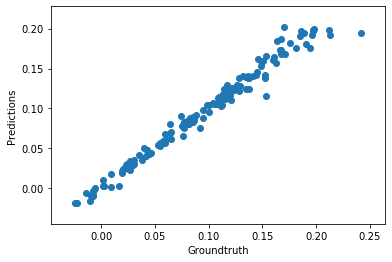

In [14]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, :3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

## Predict CoM -> y

### Linear Regression

In [16]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # Previous motion command
               X_motion_CoM_FR_RL[:, 3:6], # Current motion command
               X_motion_CoM_FR_RL[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FR_RL[:, 6:8], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_y = LinearRegression()

# Fit the model
model_fr_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.05513389409253011
RMSE:  0.0034293776581543946
The lowest error is:  4.2567118139366644e-05
The highest error is:  0.012664822507708076
The avg. error is:  0.002596272873706314


In [17]:
model_fr_com_y.coef_

array([[ 3.43586705e-03,  1.12757026e-16, -1.73472348e-16,
        -5.65124311e-04, -5.55111512e-17,  4.16333634e-17,
        -3.06995643e-02, -1.17611372e-04,  6.87480609e-02,
         9.66905695e-02, -1.47238863e-01, -3.58745927e-01,
         1.52989544e-01, -4.12726497e-01,  1.25216324e-01,
         1.51312496e-01]])

In [18]:
model_fr_com_y.intercept_

array([0.10313211])

Text(0, 0.5, 'Predictions')

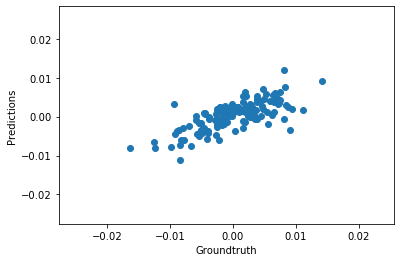

In [19]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [21]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

## Predict CoM -> Yaw

In [20]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # Previous motion command
               X_motion_CoM_FR_RL[:, 3:6], # Current motion command
               X_motion_CoM_FR_RL[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FR_RL[:, 6:8], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  -1.0831095713022507
RMSE:  0.0023842479616193236
The lowest error is:  2.842095873404303e-05
The highest error is:  0.008739390490644093
The avg. error is:  0.0018260865985544165


In [21]:
model_fl_com_theta.coef_

array([[-1.65991214e-03,  6.07153217e-18, -3.03576608e-17,
         2.50413598e-03, -3.16587034e-17,  1.38777878e-17,
        -1.02505412e-02, -1.39009478e-02, -4.54453172e-02,
         1.22635740e-01, -3.20047898e-02, -5.27735980e-02,
        -5.52945568e-02,  7.83282969e-03,  5.49739523e-02,
        -8.26919501e-02]])

In [22]:
model_fl_com_theta.intercept_

array([-0.01516997])

Text(0, 0.5, 'Predictions')

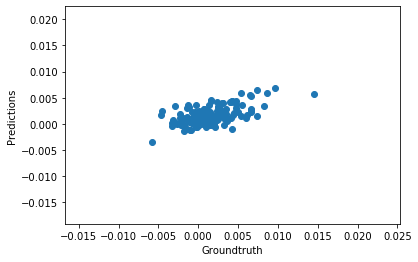

In [23]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")